# Reporting for QIIME2 metabarcoding pipeline based on DADA2

We extract outputs from the pipeline to generate :
- statistics on sequencing processing
- graphs on taxonomic profiling
- summary report

Folders :
- for fastq files: clean_data/
- for qiime2 files: qiime2_pip/
- for reporting: results/

In [24]:
import pandas as pd
import numpy as np
import glob

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

## Parameters

In [3]:
# metadata files

metadata_file = '../qiime_metadata.tsv'

# multiqc files

multiqc_fastqc_raw_file = '../clean_data/1-fastqc_raw/multiqc_data/multiqc_fastqc.txt'
multiqc_fastqc_trim_file = '../clean_data/3-fastqc_trimmed/multiqc_data/multiqc_fastqc.txt'
multiqc_fastqc_removed_file = '../clean_data/3-fastqc_removed/multiqc_data/multiqc_fastqc.txt'

multiqc_general_raw_file = '../clean_data/1-fastqc_raw/multiqc_data/multiqc_general_stats.txt'
multiqc_general_trim_file = '../clean_data/3-fastqc_trimmed/multiqc_data/multiqc_general_stats.txt'
multiqc_general_removed_file = '../clean_data/3-fastqc_removed/multiqc_data/multiqc_general_stats.txt'

# qiime2 files (some are hidden into subfolders with unique names)

getFolder = lambda dir, file: glob.glob(dir + "*")[0] + '/' + file

dada_sequences_file = getFolder('../qiime2_pip/2-dada/rep-seqs/', 'data/sequences.fasta')
dada_stats_file = getFolder('../qiime2_pip/2-dada/stats/', 'data/metadata.tsv')
dada_frequencies_file ='../qiime2_pip/2-dada/table-biom/asv-table.tsv'
diversity_shannon_file = getFolder('../qiime2_pip/4-diversity/shannon_vector_notest/', 'data/alpha-diversity.tsv')
diversity_richness_file = getFolder('../qiime2_pip/4-diversity/observed_features/', 'data/alpha-diversity.tsv')
distance_matrix_file = getFolder("../qiime2_pip/4-diversity/unweighted_unifrac_distance_matrix/", 'data/distance-matrix.tsv')
pcoa_file = getFolder("../qiime2_pip/4-diversity/unweighted_unifrac_pcoa_results/", 'data/ordination.txt')
asv_taxa_file = getFolder("../qiime2_pip/5-taxonomy/blast-taxa-tab/", 'data/metadata.tsv')

barplot_dir = "../qiime2_pip/5-taxonomy/blast-taxa-barplots/" # files: 'data/level-X.csv'

# output files

results_dir             = '../results/'
richness_fig            = results_dir + 'richness.png'
entropy_fig             = results_dir + 'shannon_entropy.png'
pcoa_fig                = results_dir + 'pcoa-plot.png'
distance_dendrogram_fig = results_dir + 'distance-plot.png'
taxon_abundances_fig    = lambda level: f'{results_dir}relative-abundances-{level}.svg'
report_file             = results_dir + 'kapil-16S-report.xlsx'
suppl_table_file        = results_dir + 'suppl_table.xlsx'

# misc
distance_matrix_method = 'Unweighted unifrac distance'
classification = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [4]:
metadata = pd.read_table(metadata_file)
metadata

,sample-id,Condition,read 1,read 2
0,21% O2,21% O2,20.rawdata_1,20.rawdata_2
1,60% O2,60% O2,60.rawdata_1,60.rawdata_2
2,100% O2,100% O2,100.rawdata_1,100.rawdata_2


## Get stats on trimmed fastq files

In [5]:
raw_stats = pd.read_table(multiqc_fastqc_raw_file, index_col=0)[['Total Sequences', 'Total Bases', '%GC']]
raw_stats['Total Sequences'] = raw_stats['Total Sequences'].astype(np.int64)
raw_stats['Sequence length - median'] = pd.read_table(multiqc_general_raw_file)['FastQC_mqc-generalstats-fastqc-median_sequence_length'].values
                     
trim_stats = pd.read_table(multiqc_fastqc_trim_file, index_col=0)[['Total Sequences', 'Total Bases', '%GC']]
trim_stats['Total Sequences'] = trim_stats['Total Sequences'].astype(np.int64)
trim_stats['Sequence length - median'] = pd.read_table(multiqc_general_trim_file)['FastQC_mqc-generalstats-fastqc-median_sequence_length'].values

removed_stats = pd.read_table(multiqc_fastqc_removed_file, index_col=0)[['Total Sequences', 'Total Bases', '%GC']]
removed_stats['Total Sequences'] = removed_stats['Total Sequences'].astype(np.int64)
removed_stats['Sequence length - median'] = pd.read_table(multiqc_general_removed_file)['FastQC_mqc-generalstats-fastqc-median_sequence_length'].values

In [6]:
# merge all stats from sequencing quality
merge = pd.merge(raw_stats, trim_stats, left_index=True, right_index=True, suffixes=(' (raw)', ' (trimmed)'))
trimming_stats = pd.merge(merge, removed_stats.add_suffix(' (rejected)'), left_index=True, right_index=True)

# rename file names to sample names
r1_names = metadata.set_index('read 1')['sample-id'].to_dict()
r2_names = metadata.set_index('read 2')['sample-id'].to_dict()
trimming_stats = trimming_stats.reset_index().replace(r1_names).replace(r2_names)
trimming_stats = trimming_stats.set_index('Sample')

# add replicate number
trimming_stats['replicate'] = [i.split('_')[-1] for i in merge.index.to_list()]
trimming_stats = trimming_stats[['replicate'] + trimming_stats.columns.tolist()]
trimming_stats = trimming_stats.iloc[:,:-1]
trimming_stats

,replicate,Total Sequences (raw),Total Bases (raw),%GC (raw),Sequence length - median (raw),Total Sequences (trimmed),Total Bases (trimmed),%GC (trimmed),Sequence length - median (trimmed),Total Sequences (rejected),Total Bases (rejected),%GC (rejected),Sequence length - median (rejected)
Sample,,,,,,,,,,,,,
100% O2,1,207445,62.2 Mbp,55.0,300,207092,57.9 Mbp,54.0,280,322,96 kbp,53.0,300
100% O2,2,207445,62.2 Mbp,54.0,300,207092,56.4 Mbp,55.0,272,322,88 kbp,54.0,272
21% O2,1,218599,65.5 Mbp,56.0,300,218183,59.7 Mbp,55.0,274,395,117.5 kbp,54.0,300
21% O2,2,218599,65.5 Mbp,55.0,300,218183,59.4 Mbp,56.0,272,395,108.4 kbp,54.0,274
60% O2,1,237000,71.1 Mbp,56.0,300,236655,64.6 Mbp,55.0,272,326,97 kbp,54.0,300
60% O2,2,237000,71.1 Mbp,55.0,300,236655,64.4 Mbp,56.0,272,326,89.2 kbp,55.0,272


## Get stats of DADA2 processing

In [7]:
# get the stats of final filtered reads and chimeras from DADA2
dada_stats = pd.read_table(dada_stats_file, index_col=0).drop('#q2:types')

# compute proportions of chimeric reads from filtered reads
filtered_reads = dada_stats['merged'].astype(np.int64)
nonchimeric_reads = dada_stats['non-chimeric'].astype(np.int64)
perc_nonchimeras = round(100 * nonchimeric_reads / filtered_reads, 2)

# compute proportions of raw reads that will be used
raw_reads = trimming_stats[trimming_stats['replicate'] == '1']['Total Sequences (raw)'].values
perc_filtered = round(100 * nonchimeric_reads / raw_reads, 2)

# format
dada_stats = dada_stats[['merged', 'non-chimeric']]
dada_stats = dada_stats.rename({'merged': 'DADA2 filtered reads',
                                'non-chimeric': 'DADA2 non-chimeric reads'}, axis=1)
dada_stats['% non chimeric reads in filtered reads'] = perc_nonchimeras
dada_stats['% non chimeric reads since raw reads'] = perc_filtered
dada_stats

,DADA2 filtered reads,DADA2 non-chimeric reads,% non chimeric reads in filtered reads,% non chimeric reads since raw reads
sample-id,,,,
100% O2,142081,105371,74.16,50.79
21% O2,150100,105679,70.41,48.34
60% O2,147718,93819,63.51,39.59


## Extract amplicons (ASV) from DADA2 output

In [8]:
# get ASV sequences

asv_names, asv_sequences = [], []

with open(dada_sequences_file, 'r') as f:
    for i, line in enumerate(f):
        if i % 2 == 0: asv_names += [line[1:].strip()]
        else: asv_sequences += [line.strip()]

amplicons_seq = pd.DataFrame(asv_sequences, index=asv_names, columns=['sequence'])
amplicons_seq['ASV length'] = amplicons_seq['sequence'].str.len()
amplicons_seq.head()

,sequence,ASV length
0aa08cf22dc02da17a3923e2c610aa85,CAAGGAATTTTCCCCAATGGGCGCCAGCCTGAGGGAGCAACGCCGC...,407
798650ec0fbe329eb98a2b3985545c79,CAAGGAATTTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGC...,406
8a6b01b2e83d044602b6e6c5ca44f827,CGACGAATATTCCGCAATGGGCGCAAGCCTGACGGAGCAATGCCGC...,404
6fd841c986cc4bd9cb65968b6b9da651,CGACGAATCTTCCGCAATGCGCGAAAGCGTGACGGAGCAATGCCGC...,404
1281a90d0859b319f61bd2c52d1b71ff,TAACGAATATTCCGCAATGCGCGAAAGCGTGACGGAGCAATGCCGC...,404


In [9]:
amplicons_stats = pd.DataFrame(round(amplicons_seq['ASV length'].describe(),2))
amplicons_stats

,ASV length
count,273.00
mean,418.51
std,11.23
min,402.00
25%,405.00
50%,424.00
75%,429.00
max,431.00


In [10]:
# get ASV frequency per sample

amplicons_frequencies = pd.read_table(dada_frequencies_file, skiprows=1, index_col=0)
amplicons_frequencies['sum across samples'] = amplicons_frequencies.sum(axis=1)
amplicons_frequencies.head()

,100% O2,21% O2,60% O2,sum across samples
#OTU ID,,,,
0aa08cf22dc02da17a3923e2c610aa85,0.0,0.0,4.0,4.0
798650ec0fbe329eb98a2b3985545c79,0.0,0.0,18.0,18.0
8a6b01b2e83d044602b6e6c5ca44f827,0.0,33.0,0.0,33.0
6fd841c986cc4bd9cb65968b6b9da651,899.0,26.0,12.0,937.0
1281a90d0859b319f61bd2c52d1b71ff,791.0,132.0,10.0,933.0


In [11]:
amplicons_frequencies.sum(axis=0).sort_values()

60% O2                 93819.0
100% O2               105371.0
21% O2                105679.0
sum across samples    304869.0
dtype: float64

In [12]:
# get taxon for each ASV

amplicons_taxa = pd.read_table(asv_taxa_file, index_col=0).drop('#q2:types')

taxa_matrix = pd.DataFrame(amplicons_taxa['Taxon'].str.split('; ').tolist(),
                           index=amplicons_taxa.index,
                           columns=['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'])
taxa_matrix.head()

,domain,phylum,class,order,family,genus,species
Feature ID,,,,,,,
006f75621a34a4ce85537c3693dc11d6,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__uncultured_bacterium
02cf65313c2218435c9eb81b7cad427a,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Halomonadaceae,g__Halomonas,None
02f9cb9291e903fe3b49861fea7a90ab,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Piscirickettsiales,f__Piscirickettsiaceae,g__Candidatus_Endoecteinascidia,None
0360a498b5585f9028fa802e6b4f7bf5,d__Bacteria,p__Firmicutes,c__Negativicutes,o__Veillonellales-Selenomonadales,f__Veillonellaceae,g__Dialister,s__uncultured_bacterium
0474e39d6e48273efcf0247e78d96ec7,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,None,None,None,None


In [13]:
# merge taxa and frequencies of ASV

amplicons_table = pd.merge(amplicons_frequencies, taxa_matrix, left_index=True, right_index=True)
amplicons_table = pd.merge(amplicons_table, amplicons_seq, left_index=True, right_index=True)
amplicons_table.index.name = 'ASV ID'
amplicons_table.head()

,100% O2,21% O2,60% O2,sum across samples,domain,phylum,class,order,family,genus,species,sequence,ASV length
ASV ID,,,,,,,,,,,,,
0aa08cf22dc02da17a3923e2c610aa85,0.0,0.0,4.0,4.0,d__Bacteria,p__Chloroflexi,c__Chloroflexia,o__Thermomicrobiales,f__AKYG1722,g__AKYG1722,None,CAAGGAATTTTCCCCAATGGGCGCCAGCCTGAGGGAGCAACGCCGC...,407
798650ec0fbe329eb98a2b3985545c79,0.0,0.0,18.0,18.0,d__Bacteria,p__Chloroflexi,c__Chloroflexia,o__Thermomicrobiales,f__JG30-KF-CM45,g__JG30-KF-CM45,s__uncultured_bacterium,CAAGGAATTTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGC...,406
8a6b01b2e83d044602b6e6c5ca44f827,0.0,33.0,0.0,33.0,d__Bacteria,p__Planctomycetota,c__Phycisphaerae,o__Phycisphaerales,f__Phycisphaeraceae,g__SM1A02,s__uncultured_bacterium,CGACGAATATTCCGCAATGGGCGCAAGCCTGACGGAGCAATGCCGC...,404
6fd841c986cc4bd9cb65968b6b9da651,899.0,26.0,12.0,937.0,d__Bacteria,p__Planctomycetota,c__Phycisphaerae,o__Phycisphaerales,f__Phycisphaeraceae,g__SM1A02,None,CGACGAATCTTCCGCAATGCGCGAAAGCGTGACGGAGCAATGCCGC...,404
1281a90d0859b319f61bd2c52d1b71ff,791.0,132.0,10.0,933.0,d__Bacteria,p__Planctomycetota,c__Phycisphaerae,o__Phycisphaerales,f__Phycisphaeraceae,g__SM1A02,None,TAACGAATATTCCGCAATGCGCGAAAGCGTGACGGAGCAATGCCGC...,404


## Get diversity stats

### Richness

In [14]:
# get richness

richness = pd.read_table(diversity_richness_file, index_col=0)
richness.columns=['Number of ASVs']
richness = richness.loc[metadata['sample-id']]
richness

,Number of ASVs
21% O2,148
60% O2,159
100% O2,185


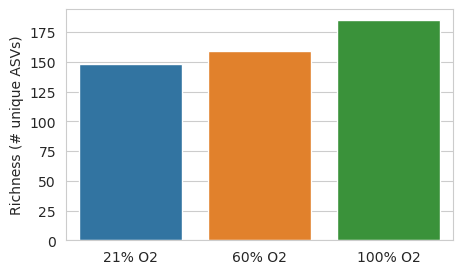

In [15]:
fig, ax = plt.subplots(figsize=(5,3))

sns.barplot(data=richness.reset_index(), x='index', y='Number of ASVs', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
ax.set_xlabel('')
ax.set_ylabel('Richness (# unique ASVs)')

fig.savefig(richness_fig, format='png', bbox_inches='tight', dpi=140)

### Shannon diversity

In [16]:
# get shannon diversity

shannon = pd.read_table(diversity_shannon_file, index_col=0)
shannon = shannon.loc[metadata['sample-id']]
shannon

,shannon_entropy
21% O2,3.672338
60% O2,4.079555
100% O2,3.988279


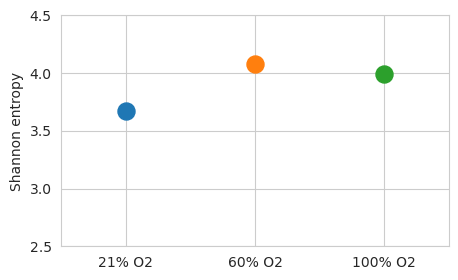

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

shannon.plot.bar(ax=ax, color=(0,0,0,0), edgecolor=(0,0,0,0))

for i in range(len(shannon)):
    ax.scatter(shannon.index[i], shannon.values[i], s=150)

ax.set_yticks([2.5, 3, 3.5, 4, 4.5])
ax.set_ylim([2.5, 4.5])
ax.get_legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy')

fig.savefig(entropy_fig, format='png', bbox_inches='tight', dpi=140)

### Unweighted-Unifrac Distance matrix

In [18]:
# get distance matrix

distance_matrix = pd.read_table(distance_matrix_file, index_col=0)
distance_matrix.index.name = distance_matrix_method
distance_matrix

,100% O2,21% O2,60% O2
Unweighted unifrac distance,,,
100% O2,0.000000,0.386415,0.372303
21% O2,0.386415,0.000000,0.360178
60% O2,0.372303,0.360178,0.000000


#### PCoA plot

In [19]:
with open(pcoa_file, 'r') as f: lines = f.readlines()

#extract variance explained per axis and convert to human readable value
variance_explained = lines[4].strip().split('\t')
variance_explained = [str(round(float(v)*100,1)) + '%' for v in variance_explained]

#extract coordinates of each point from the PCoA
coordinates = [line.strip().split('\t') for line in lines[9:12]]
coordinates = pd.DataFrame(coordinates).set_index(0).astype(np.float64)
coordinates

,1,2,3
0,,,
100% O2,0.214743,-0.058780,-0.0
21% O2,-0.162600,-0.142022,-0.0
60% O2,-0.052142,0.200801,-0.0


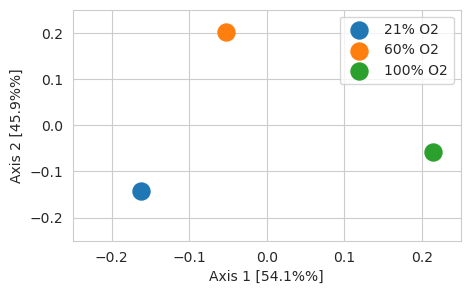

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))

for sample in metadata['sample-id']:
    ax.scatter(*coordinates.loc[sample, [1,2]].values, s=150, label=sample)

ax.set_xlabel(f'Axis 1 [{variance_explained[0]}%]')
ax.set_ylabel(f'Axis 2 [{variance_explained[1]}%]')
ax.legend()
ax.set_xticks(np.arange(-0.2, 0.4, 0.1).round(2))
ax.set_yticks(np.arange(-0.2, 0.4, 0.1).round(2))
ax.set_xlim([-0.25, 0.25])
ax.set_ylim([-0.25, 0.25])

fig.savefig(pcoa_fig, format='png', bbox_inches='tight', dpi=140)
plt.show()

#### Dendrogram

In [29]:
distance_matrix

,100% O2,21% O2,60% O2
Unweighted unifrac distance,,,
100% O2,0.000000,0.386415,0.372303
21% O2,0.386415,0.000000,0.360178
60% O2,0.372303,0.360178,0.000000


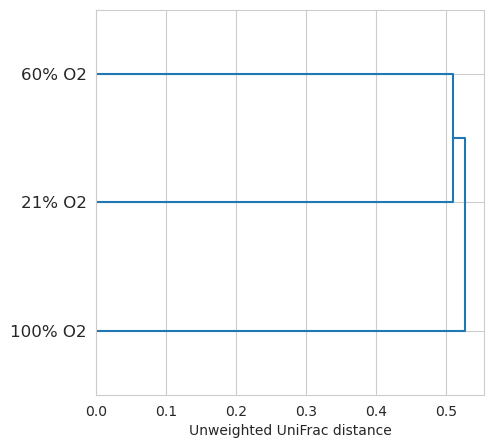

In [30]:
Z = linkage(pdist(distance_matrix), method='single')

fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, ax=ax, labels=distance_matrix.index, orientation='right')
plt.xlabel('Unweighted UniFrac distance')

fig.savefig(distance_dendrogram_fig, format='png', bbox_inches='tight')
plt.show()

### Relative abundances

In [21]:
def makeTaxonAbundanceDataframe(level): 
    """prepare a table with ASV abundances per taxon"""

    # extract taxon abundances from file
    taxon_abundances = pd.read_table(
        getFolder(barplot_dir, f'data/level-{str(level)}.csv'),
        sep=',', index_col=0
    )

    # remove unwanted columns that come from metadata file
    expected_columns = taxon_abundances.columns.difference(metadata.columns)
    taxon_abundances = taxon_abundances[expected_columns]
    taxon_abundances = taxon_abundances.T

    # format the index into a MultiIndex
    exploded_index = pd.MultiIndex.from_tuples(taxon_abundances.index.str.split(';').tolist())
    taxon_abundances.index = exploded_index

    # put columns in good order
    taxon_abundances = taxon_abundances[metadata['sample-id']]

    # compute relative abundances
    relative_abundances = round(100 * taxon_abundances / taxon_abundances.sum(), 2)

    # get unique ASV across samples for each taxon
    unique_asv = amplicons_table.reset_index().groupby(classification[:level])['ASV ID'].count()

    # format
    unique_asv.name = '# unique ASVs'
    taxon_abundances.index = taxon_abundances.index.set_names(classification[:level])
    taxon_abundances.columns = taxon_abundances.columns + ' (# abundance)'
    relative_abundances.columns = relative_abundances.columns + ' (% rel abundance)'
    relative_abundances.index = relative_abundances.index.set_names(classification[:level])

    # merge the dataframes
    return pd.merge(
        unique_asv.to_frame().reset_index(),
        taxon_abundances.reset_index(),
        left_on=classification[:level],
        right_on=classification[:level]
    ).merge(
        relative_abundances.reset_index(),
        left_on=classification[:level],
        right_on=classification[:level]
    ).set_index(classification[:level])

# retrieve taxa abundances

taxon_abundances = {
    level: makeTaxonAbundanceDataframe(i+1)
    for i, level in enumerate(classification)
}

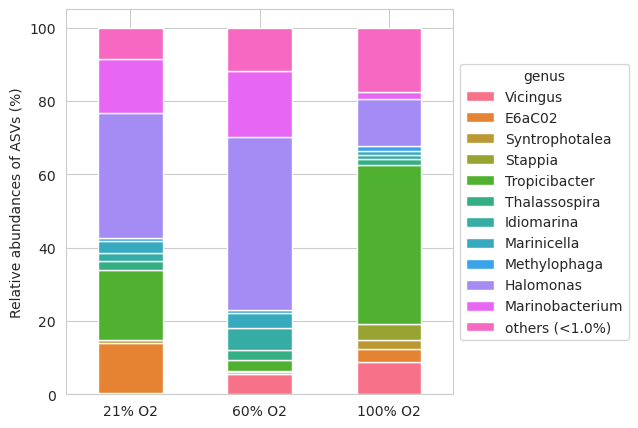

In [22]:
def extractTaxaToPlot(taxon_abundances, cutoff):
    """extract relative abundances for each taxon"""
    df = taxon_abundances.copy()
    
    # extract species with low abundances
    low_abundances =  df[df.sum(axis=1) / df.sum().sum() < cutoff]
    
    # extract species with high abundances
    high_abundances = df.loc[~df.index.isin(low_abundances.index)]
    #high_abundances = high_abundances.loc[high_abundances.sum(axis=1).sort_values(ascending=False).index]
    
    # make the sum of low abundances species
    others_abundances = low_abundances.sum().to_frame(f'others (<{cutoff*100}%)').T

    total_abundances = pd.concat([high_abundances, others_abundances])
    total_abundances = 100 * total_abundances / total_abundances.sum()
    
    return total_abundances

def plotTaxonAbundances(df, level, cutoff, colors):
    """plot abundances"""
    fig, ax = plt.subplots(figsize=(5,5))

    # prepare the dataframe that we want to plot
    abundances = df[df.columns[['# abundance' in c for c in df.columns]]]
    to_plot = extractTaxaToPlot(abundances, cutoff=cutoff).T
    to_plot.index = metadata['sample-id']
    to_plot = to_plot.loc[metadata['sample-id']]
    
    to_plot.plot(kind='bar', stacked=True, ax=ax, color=colors)
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [item.split(', ')[-1].split('_')[-1][:-1] if 'others' not in item else item for item in labels]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='genus')
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
    ax.set_xlabel('')
    ax.set_ylabel('Relative abundances of ASVs (%)')
    
    fig.savefig(taxon_abundances_fig(level), format='svg', bbox_inches='tight', dpi=140)
    plt.show()

plotTaxonAbundances(taxon_abundances['genus'], 'genus', 0.01, sns.color_palette("husl", n_colors=12))

## Make report

### Create data report

In [23]:
with pd.ExcelWriter(report_file) as writer:
    trimming_stats.to_excel(writer, sheet_name="1. Trimming ")
    dada_stats.to_excel(writer, sheet_name="2. Processed reads")
    amplicons_stats.to_excel(writer, sheet_name="3. Amplicons stats")
    amplicons_table.to_excel(writer, sheet_name="3. Amplicons seqs")
    richness.to_excel(writer, sheet_name="4. Richness")
    shannon.to_excel(writer, sheet_name="4. Shannon")
    distance_matrix.to_excel(writer, sheet_name="4. Distances")
    for c in classification:
        taxon_abundances[c].to_excel(writer, sheet_name=f"5. Taxa ({c})", merge_cells=False)

### make supplementary table with other lineages < 0.1%

In [24]:
# compute ASV abundances across samples
df = taxon_abundances['genus'].iloc[:,1:4]
sum_across_samples = df.sum(axis=1) / df.sum(axis=1).sum()
abundant_genus = df.loc[sum_across_samples * 100 >= 0.1]

# make "others" line
others = df.loc[sum_across_samples * 100 < 0.1].sum().to_frame().T
others_index = ['others' if i == 0 else '-' for i in range(len(abundant_genus.index[0]))]
others.index = pd.MultiIndex.from_tuples([others_index])

# make suppl table with relative abundances
suppl_table = pd.concat([abundant_genus, others])
suppl_table.columns = [0.2, 0.6, 1.0]
suppl_table = (100 * suppl_table / suppl_table.sum()).round(3)
suppl_table['# unique ASVs'] = taxon_abundances['genus']['# unique ASVs']

# compute unique ASVs for "others" line
low_abudances_taxa = df.loc[sum_across_samples * 100 < 0.1].index
low_abudances_ASV = amplicons_table.set_index(classification[:-1]).loc[low_abudances_taxa]
suppl_table.loc[[others_index],'# unique ASVs'] = len(low_abudances_ASV)

# format
suppl_index = [[t.split('__')[-1] for t in id] for id in suppl_table.index]
suppl_table.index = pd.MultiIndex.from_tuples(suppl_index)
suppl_table = suppl_table.sort_values([0.2, 0.6, 1.0], ascending=False)

In [26]:
with pd.ExcelWriter(suppl_table_file) as writer:
    suppl_table.to_excel(writer, merge_cells=False)